In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numba import cuda, jit
import math
import time

In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.30GHz
    CPU family:          6
    Model:               63
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4599.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp

In [2]:
!nvidia-smi

Mon Dec 18 15:54:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
def cpu_processing(image, buffer):
    result_image = np.zeros_like(image)
    for w in range(image.shape[0]):
        for h in range(image.shape[1]):
            tmp = 0
            weighted_sum = 0
            for i in range(w - buffer[1], w + buffer[1] + 1):
                for j in range(h - buffer[1], h+buffer[1] + 1):
                    if i >=0 and i< image.shape[0] and j >=0 and j < image.shape[1]:
                        diff = int(image[w,h]) - int(image[i,j])
                        weight = np.exp(-(diff**2)/(2*buffer[0]**2))
                        tmp+=weight*image[i,j]
                        weighted_sum +=weight
            if weighted_sum ==0:
                result_image[w,h] = image[w,h]
            else:
                result_image[w,h] = tmp/weighted_sum
    return result_image

@cuda.jit
def cuda_kernel(image, result_image, buffer):
    idx, jdx = cuda.grid(2)
    if idx < image.shape[0] and jdx < image.shape[1]:
        x = idx
        y = jdx
        sum = 0.
        weighted_sum = 0.
        for i in range(x - buffer[1], x + buffer[1] + 1):
            for j in range(y - buffer[1], y + buffer[1] + 1):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    diff = image[x, y] - image[i, j]
                    weight = math.exp(-((diff ** 2) / (2 * buffer[0] ** 2)))
                    sum += weight * image[i, j]
                    weighted_sum += weight
        if weighted_sum ==0:
            result_image[x,y] = image[x,y]
        else:
            result_image[x,y] = sum/weighted_sum


def gpu_processing(image,buffer):
    threads_per_block = (16,16)
    blocks_per_grid = (math.ceil(image.shape[0]/threads_per_block[0]), math.ceil(image.shape[1]/ threads_per_block[1]))

    image_cuda = cuda.to_device(image)
    result_cuda = cuda.to_device(np.zeros_like(image,dtype=np.float32))
    buffer_cuda = cuda.to_device(np.array(buffer,dtype=np.float32))

    cuda_kernel[blocks_per_grid, threads_per_block](image_cuda, result_cuda, buffer_cuda)

    return result_cuda.copy_to_host()

In [126]:
!wget https://raw.githubusercontent.com/MyCatsGitHub/HPC_labs/main/Bilateral%20filtering/mood.bmp \
https://raw.githubusercontent.com/MyCatsGitHub/HPC_labs/main/Bilateral%20filtering/sharikov.bmp

--2023-12-18 18:39:50--  https://raw.githubusercontent.com/MyCatsGitHub/HPC_labs/main/Bilateral%20filtering/mood.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230538 (225K) [image/bmp]
Saving to: ‘mood.bmp.1’

mood.bmp.1          100%[===================>] 225.13K  --.-KB/s    in 0.03s   

2023-12-18 18:39:51 (8.59 MB/s) - ‘mood.bmp.1’ saved [230538/230538]

--2023-12-18 18:39:51--  https://raw.githubusercontent.com/MyCatsGitHub/HPC_labs/main/Bilateral%20filtering/sharikov.bmp
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1759098 (1.7M) [image/bmp]
Saving to: ‘sharikov.bmp’

sharikov.bmp        100%[===================>]   1.68M  --.-KB/s    in 0.03s   

2023-12-18 18:39:51 (62.1 MB

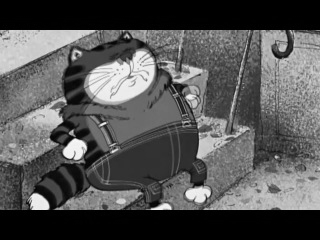

In [81]:
img = cv2.imread('mood.bmp',cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [121]:
blur = 40
sigma_d = 3
buffer = [blur, sigma_d]

CPU time: 10.78489875793457


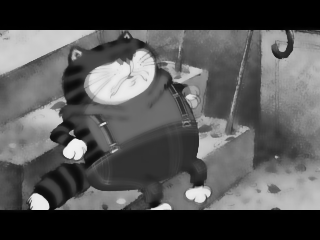

GPU time: 0.0071258544921875


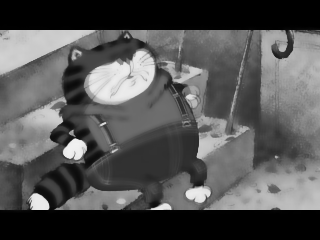

Boost: 1513.4884903640257


In [125]:
start = time.time()
result_cpu = np.array(cpu_processing(img, buffer))
end_cpu = time.time() - start
print(f'CPU time: {end_cpu}')
cv2_imshow(result_cpu)

start = time.time()
result_gpu  = np.array(gpu_processing(img, buff))
end_gpu = time.time() - start
print(f'GPU time: {end_gpu}')
cv2_imshow(result_gpu)
print(f'Boost: {end_cpu/end_gpu}')

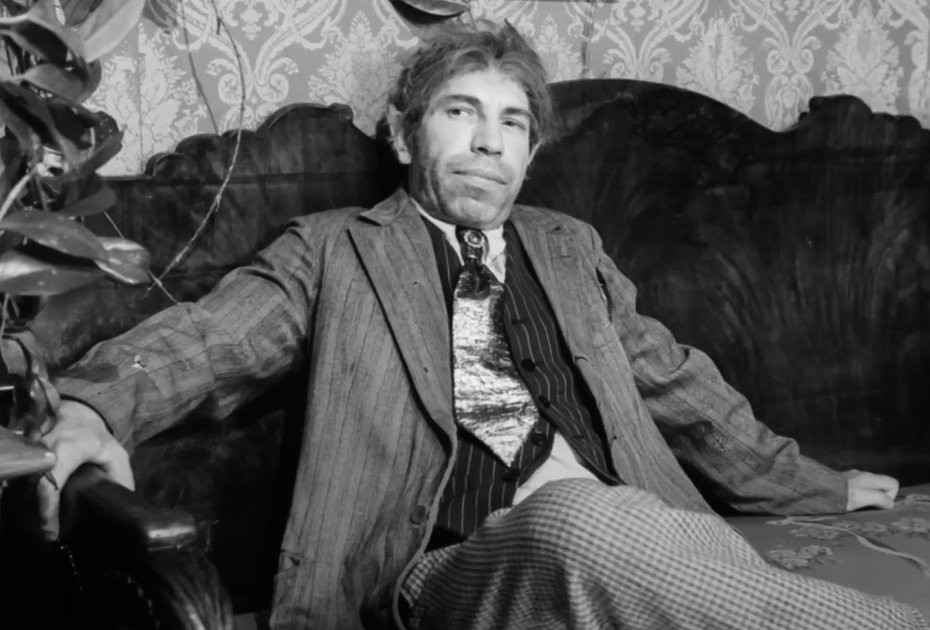

In [127]:
img = cv2.imread('sharikov.bmp',cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

CPU time: 82.37857913970947


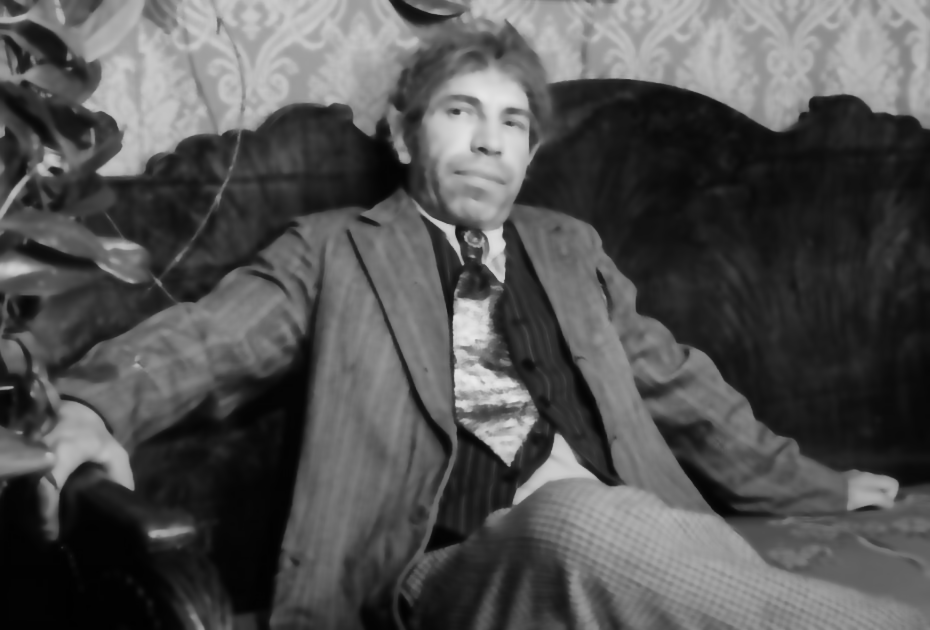

GPU time: 0.040543556213378906


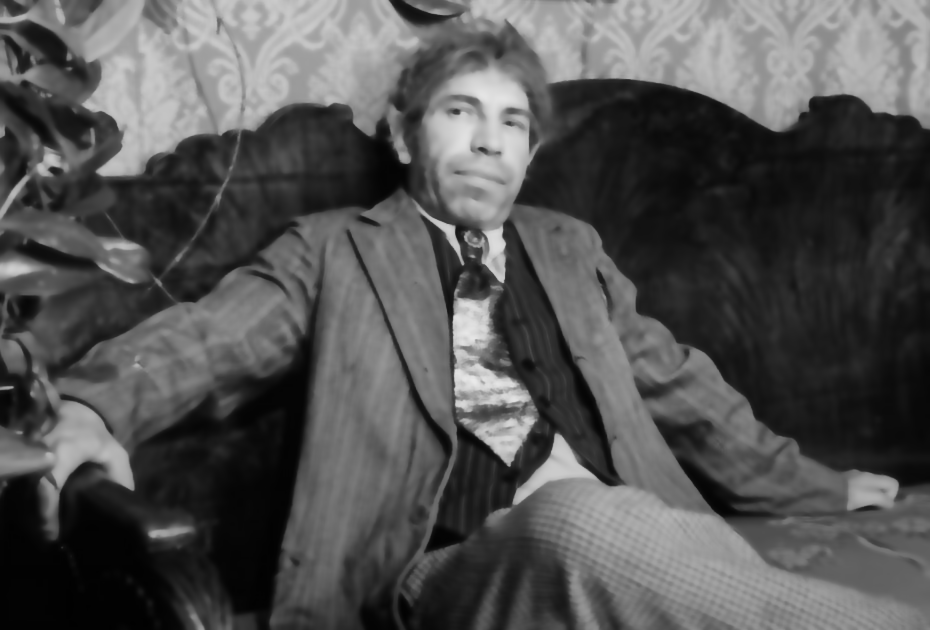

Boost: 2031.853809423


In [128]:
start = time.time()
result_cpu = np.array(cpu_processing(img, buffer))
end_cpu = time.time() - start
print(f'CPU time: {end_cpu}')
cv2_imshow(result_cpu)

start = time.time()
result_gpu  = np.array(gpu_processing(img, buff))
end_gpu = time.time() - start
print(f'GPU time: {end_gpu}')
cv2_imshow(result_gpu)
print(f'Boost: {end_cpu/end_gpu}')